# Synthetix Perpetual Futures


In [477]:
from variables import *
import numpy as np
import matplotlib.pyplot as plt

## Parameters


### Market and Position Parameters


#### Position Size

-   Measured in units of the base asset (e.g. position "worth" 10 $BTC will have `position_size = 10`)
-   Long positions are positive, short positions are negative


In [478]:
position_size = (initial_margin * initial_leverage) / initial_base_asset_spot_price


def calculate_position_size(
    initial_margin, initial_leverage, initial_base_asset_spot_price
):
    return (initial_margin * initial_leverage) / initial_base_asset_spot_price

#### Notional Value

-   The (signed) value of the base currency units on a position
-   long positions are positive, short positions are negative


Current Notional Value


In [479]:
notional_value = position_size * base_asset_spot_price


def calculate_notional_value(position_size, base_asset_spot_price):
    return position_size * base_asset_spot_price

Initial Notional Value


In [480]:
initial_notional_value = initial_margin * initial_leverage


def calculate_initial_notional_value(initial_margin, initial_leverage):
    return initial_margin * initial_leverage

#### Profit and Loss (PnL)

-   The profit in a position is the change in its notional value since entry


In [481]:
profit_and_loss = notional_value - initial_notional_value


def calculate_profit_and_loss(notional_value, initial_notional_value):
    return notional_value - initial_notional_value

#### Market Size

-   Total size of all outstanding positions in the market


In [482]:
market_size = (
    sum(set_of_all_positions_in_the_market)
    if sum(set_of_all_positions_in_the_market)
    == set_of_all_long_positions_in_the_market
    + set_of_all_short_positions_in_the_market
    else Exception("Market size calculation error")
)


def calculate_market_size(
    set_of_all_positions_in_the_market,
    set_of_all_long_positions_in_the_market,
    set_of_all_short_positions_in_the_market,
):
    total_market_size = sum(set_of_all_positions_in_the_market)
    if (
        total_market_size
        == set_of_all_long_positions_in_the_market
        + set_of_all_short_positions_in_the_market
    ):
        return total_market_size
    else:
        raise Exception("Market size calculation error")

#### Market skew

-   Ratio of long to short positions in the market (relative to position_size)
-   Positive skew means more longs than shorts
-   Negative skew means more shorts than longs


In [483]:
market_skew = sum(position.size for position in set_of_all_positions_in_the_market)


def calculate_market_skew(set_of_all_positions_in_the_market):
    return sum(position.size for position in set_of_all_positions_in_the_market)

### Leverage and Margins Parameters


#### Leverage

-   The ratio of notional value to margin
-   λ = v / m


Current Leverage


In [484]:
leverage = notional_value / remaining_margin


def calculate_leverage(notional_value, remaining_margin):
    return notional_value / remaining_margin

Initial Leverage


In [485]:
initial_leverage = initial_notional_value / initial_margin


def calculate_initial_leverage(initial_notional_value, initial_margin):
    return initial_notional_value / initial_margin

#### Margin


Initial Margin


In [486]:
initial_margin = position_size * initial_base_asset_spot_price / initial_leverage


def calculate_initial_margin(
    position_size, initial_base_asset_spot_price, initial_leverage
):
    return (position_size * initial_base_asset_spot_price) / initial_leverage

Remaining Margin

-   if remaining_margin < 0, position is liquidated


In [487]:
remaining_margin = max(initial_margin + profit_and_loss + accrued_position_funding, 0)


def calculate_remaining_margin(
    initial_margin, profit_and_loss, accrued_position_funding
):
    return max(initial_margin + profit_and_loss + accrued_position_funding, 0)

Position Debt

-   Margin "owed" to the "system" (i.e. margin that must be paid back to close the position)
    -   When a position is closed, the funds in its margin are settled. After profit and funding are computed, the remaining margin will be minted into the account that created the position, while any losses out of the initial margin, will be minted into the fee pool."


In [488]:
position_debt = abs(initial_notional_value) - initial_margin


def calculate_position_debt(initial_notional_value, initial_margin):
    return abs(initial_notional_value) - initial_margin

### Exchange Fees

-   Fees are imposed when a position is (1) opened, (2) increased


#### Maker

-   A maker is a trader who is reducing skew in the market.
    -   If the market is long skew, a maker is a trader who is opening a short position. If the market is short skew, a maker is a trader who is opening a long position.


#### Taker

-   A taker is a trader who is increasing skew in the market.
    -   If the market is long skew, a taker is a trader who is opening a long position. If the market is short skew, a taker is a trader who is opening a short position.


#### Fees

-   fees will be charged out of the user's remaining margin
    -   since fees are charged out of the remaining margin, they will affect the user's leverage


### Skew Funding Rate


💡

-   Term: Market Skew
    -   Market Skew refers to the difference in open interest between long and short positions in the market
    -   A positive Market Skew indicates that the total open interest in long positions exceeds that in short positions
        -   suggests a market inclination towards rising prices
    -   A negative Market Skew suggests that the total open interest in short positions surpasses that in long positions
        -   suggests a market tendency towards falling prices
-   Term: Funding Rate
    -   The funding rate has the opposite sign to the skew, as funding flows "against capital in the market"
    -   When the funding rate is positive, shorts pay longs
    -   When the funding rate it is negative, longs pay shorts


#### Proportional Skew

-   The skew normalized by the skew scaling constant.


In [489]:
proportional_skew = market_skew / skew_scaling_denominator_constant


def calculate_proportional_skew(market_skew, skew_scaling_denominator_constant):
    return market_skew / skew_scaling_denominator_constant

### Instantaneous Funding Rate


-   Funding accumulates continuously; changes in **market skew** or **base asset price** affect funding for all open positions
-   Frequent updates between opening and closing positions are costly
-   Total accrued funding per base currency unit is recorded whenever the skew changes; individual position funding is calculated from this
-   Funding calculations use the spot rates at the time of skew changes, even though the base asset price may vary in between
-   If the market is active, any funding inaccuracies due to this method are typically minor


The Funding Rate is represented numerically as a percentage

-   The funding rate is paid/received per position based on **Position Size**


In [539]:
instantaneous_funding_rate = (
    np.clip((-proportional_skew / max_funding_skew_threshold), -1, 1) * max_funding_rate
)


def calculate_instantaneous_funding_rate(
    proportional_skew, max_funding_skew_threshold, max_funding_rate
):
    return (
        np.clip((-proportional_skew / max_funding_skew_threshold), -1, 1)
        * max_funding_rate
    )

### Aggregate Debt Calculation


#### Total Debt

-   The overall market debt is the sum of the remaining margin in all positions


Aggregate Position Entry Debt Correction


In [540]:
aggregate_position_entry_debt_correction = (
    market_skew * (base_asset_spot_price + unrecorded_cumulative_funding)
) + np.sum(
    [
        (
            position.initial_margin
            - position.initial_notional_value
            - (
                position.position_size
                * position.unrecorded_cumulative_funding_at_last_modified_index
            )
        )
        for position in set_of_all_positions_in_the_market
    ]
)


def calculate_aggregate_position_entry_debt_correction(
    set_of_all_positions_in_the_market,
    market_skew,
    base_asset_spot_price,
    unrecorded_cumulative_funding,
):
    return (
        market_skew * (base_asset_spot_price + unrecorded_cumulative_funding)
    ) + np.sum(
        [
            (
                position.initial_margin
                - position.initial_notional_value
                - (
                    position.position_size
                    * position.unrecorded_cumulative_funding_at_last_modified_index
                )
            )
            for position in set_of_all_positions_in_the_market
        ]
    )

Market Debt


In [541]:
market_debt = max(
    market_skew * (base_asset_spot_price + unrecorded_cumulative_funding)
    + aggregate_position_entry_debt_correction,
    0,
)


def calculate_market_debt(
    market_skew,
    base_asset_spot_price,
    unrecorded_cumulative_funding,
    aggregate_position_entry_debt_correction,
):
    return max(
        market_skew * (base_asset_spot_price + unrecorded_cumulative_funding)
        + aggregate_position_entry_debt_correction,
        0,
    )

### Liquidations and Keepers


#### Liquidation margin

-   Liquidation margin below which a position will be liquidatable
-   It is a function of current spot price


In [542]:
liquidation_margin = max(
    position_size * base_asset_spot_price * liquidation_fee_ratio,
    minimal_keeper_incentive,
) + (position_size * base_asset_spot_price * liquidation_buffer_ratio)


def calculate_liquidation_margin(
    position_size,
    base_asset_spot_price,
    liquidation_fee_ratio,
    minimal_keeper_incentive,
    liquidation_buffer_ratio,
):
    return np.maximum(
        position_size * base_asset_spot_price * liquidation_fee_ratio,
        minimal_keeper_incentive,
    ) + (position_size * base_asset_spot_price * liquidation_buffer_ratio)

Minimal keeper incentive

-   The minimum incentive for a keeper to liquidate a position (in futures v1 this value was set to 20 $sUSD)


Liquidation buffer ratio

-   Ratio of notional position size that will be used as buffer to reduce chance of negative margin on large price updates


Liquidation fee ratio

-   Ratio of notional position size that will be paid to incentive liquidation keepers


Approxime liquidation price

-   Approximate liquidation price as estimated using liquidation margin calculated for current price
-   Will be above actual liquidation price for longs, and below for shorts


In [543]:
approximate_liquidation_price = (
    initial_base_asset_spot_price
    - ((initial_margin - liquidation_margin) / position_size)
    - (
        unrecorded_cumulative_funding
        - unrecorded_cumulative_funding_at_last_modified_index
    )
)


def calculate_approximate_liquidation_price(
    initial_base_asset_spot_price,
    initial_margin,
    liquidation_margin,
    position_size,
    unrecorded_cumulative_funding,
    unrecorded_cumulative_funding_at_last_modified_index,
):
    return (
        initial_base_asset_spot_price
        - ((initial_margin - liquidation_margin) / position_size)
        - (
            unrecorded_cumulative_funding
            - unrecorded_cumulative_funding_at_last_modified_index
        )
    )

## Payoffs


### Basic Payoff Analysis


Entry Margin

-   Units: $USD


In [544]:
m_e = 100

Entry Leverage

-   Units: N/A


In [545]:
λ_e = 1

Entry Spot Price of Base Asset

-   Units: $ASSET/$USD


In [546]:
b_e = 1000

Change in Spot Price of Base Asset (since entry)

-   Units: $ASSET/$USD


In [547]:
Δb = np.linspace(1000, 4000, 100)

Payoff (as a function of spot price)

-   Units: $USD


In [548]:
payoff = calculate_profit_and_loss(
    calculate_notional_value(
        calculate_position_size(
            m_e,
            λ_e,
            b_e,
        ),
        Δb,
    ),
    calculate_initial_notional_value(m_e, λ_e),
)

Linear Plot of Payoff (as a function of spot price)


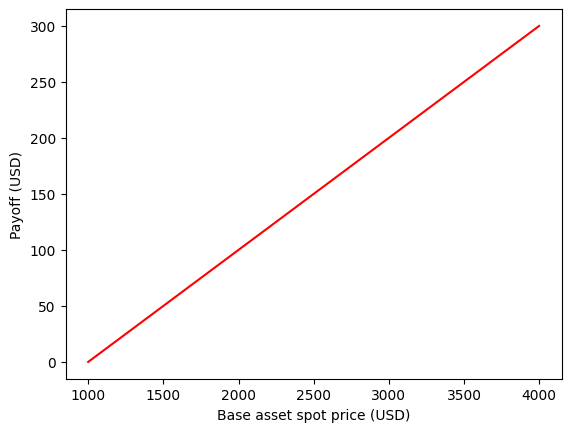

In [549]:
plt.plot(Δb, payoff, "r")
plt.ylabel("Payoff (USD)")
plt.xlabel("Base asset spot price (USD)")
plt.show()

### Basic Liquidation Analysis


Entry Margin

-   Units: $USD


In [550]:
m_e = 100

Entry Leverage

-   Units: N/A


In [551]:
λ_e = 1

Entry Spot Price of Base Asset

-   Units: $ASSET/$USD


In [552]:
b_e = 1000

Change in Spot Price of Base Asset (since entry)

-   Units: $ASSET/$USD


In [553]:
Δb = np.linspace(1000, 4000, 100)

Liquidation Fee Ratio

-   Units: Basis Points (BPS)


In [554]:
r_fee = 35 / 10000

Minimal Keeper Incentive

-   Units: $USD


In [555]:
D = 20

Liquidation Buffer Ratio

-   Units: Basis Points (BPS)


In [556]:
r_buffer = 1 / 10000

Liquidation Margin (amount of margin below which the position can be liquidated)

-   Units: $USD


In [557]:
liq_margin = calculate_liquidation_margin(
    calculate_position_size(
        m_e,
        λ_e,
        b_e,
    ),
    Δb,
    r_fee,
    D,
    r_buffer,
)

Linear Plot of Liquidation Margin (as a function of spot price)


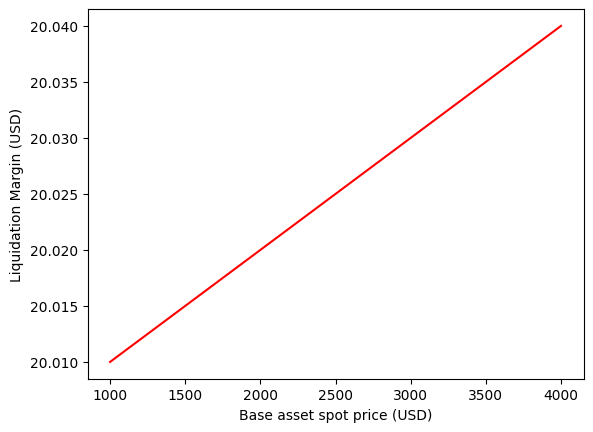

In [558]:
plt.plot(Δb, liq_margin, "r")
plt.ylabel("Liquidation Margin (USD)")
plt.xlabel("Base asset spot price (USD)")
plt.show()

Liquidation Price

-   Units: $ASSET/$USD


In [559]:
liq_price = calculate_approximate_liquidation_price(
    b_e,
    m_e,
    liq_margin,
    calculate_position_size(
        m_e,
        λ_e,
        b_e,
    ),
    0,  # assume unrecorded cumulative funding is nil
    0,  # assume unrecorded cumulative funding at last index is nil
)

Linear Plot of Liquidation Price (as a function of spot price)


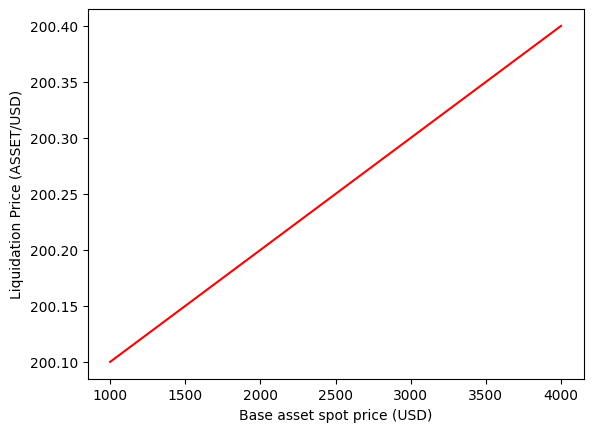

In [560]:
plt.plot(Δb, liq_price, "r")
plt.ylabel("Liquidation Price (ASSET/USD)")
plt.xlabel("Base asset spot price (USD)")
plt.show()

#### Liquidation Events given Standard Linear Payoff


Change in Spot Price of Base Asset (since entry)

-   Units: $ASSET/$USD


In [561]:
Δb = np.linspace(4000, 0, 100)

Payoff (as a function of spot price)

-   Units: $USD
-   Takes liquidation into consideration


In [562]:
liq_margin = calculate_liquidation_margin(
    calculate_position_size(
        m_e,
        λ_e,
        b_e,
    ),
    Δb,
    r_fee,
    D,
    r_buffer,
)

liq_price = calculate_approximate_liquidation_price(
    b_e,
    m_e,
    liq_margin,
    calculate_position_size(
        m_e,
        λ_e,
        b_e,
    ),
    0,  # assume unrecorded cumulative funding is nil
    0,  # assume unrecorded cumulative funding at last index is nil
)

payoff = calculate_profit_and_loss(
    calculate_notional_value(
        calculate_position_size(
            m_e,
            λ_e,
            b_e,
        ),
        Δb,
    ),
    calculate_initial_notional_value(m_e, λ_e),
)


liq_condition = Δb <= liq_price
payoff = np.where(liq_condition, -m_e, payoff)

Non-Linear Plot of Payoff (as a function of spot price)


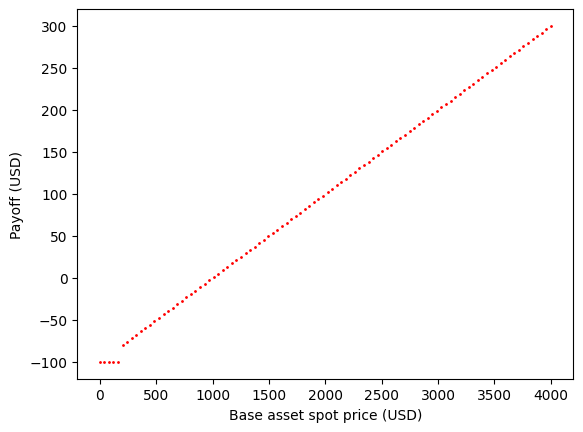

In [563]:
plt.plot(Δb, payoff, "r.", markersize=2)
plt.ylabel("Payoff (USD)")
plt.xlabel("Base asset spot price (USD)")
plt.show()